# Continuous Normalizing Flow tutorial: training ODE generative models using maximum likelihood

This implements a [continuous normalizing flow (CNF)](https://arxiv.org/abs/1806.07366) trained using maximum likelihood.

To compute the likelihood of a sample $x_1$ we use the instantaneous change of variables formula integrated over time that is we have

$$
\begin{pmatrix}
\partial x_t / \partial t \\
\partial \log p(x_t) / \partial t
\end{pmatrix} = 
 \begin{pmatrix}
f(t, x_t)\\
-\text{tr}(\partial f / \partial x_t)
\end{pmatrix} 
$$

which is implemented as a $d+1$ dimensional system. There are two common ways to calculate $\partial \log p(x_t) / \partial t$.
* Exact calcuation of the trace of the Jacobian with essentially $D$ calls of $f$.
* Hutchinson trace estimator either with a normal distribution or Rademacher distribution. Which uses
  $$
    \text{tr}(\partial f / \partial x_t) = \mathbb{E}_{\epsilon} \left [ \epsilon^T [\partial f / \partial x_t] \epsilon \right ]
  $$
  and can be used with a single call to $f$. $\epsilon$ must be distributed such that $\mathbb{E}(\epsilon) = 0$ and $\text{Cov}(\epsilon) = I$. Most often Gaussian or Rademacher distributions are used, and are both implemented here.

As compared to flow matching methods, this requires a calculation of the trace of the Hessian and backpropagation through time so is signficantly slower and more numerically unstable to train.

Note: Requires a version of torch with `vmap` and `torch.func.jacrev`.

In [1]:
import time

import torch
from torch.distributions import MultivariateNormal
from torchdyn.core import NeuralODE

from torchcfm.models import MLP
from torchcfm.utils import plot_trajectories, sample_moons

In [2]:
class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, *args, **kwargs):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def exact_div_fn(u):
    """Accepts a function u:R^D -> R^D."""
    J = torch.func.jacrev(u)
    return lambda x, *args: torch.trace(J(x))


def div_fn_hutch_trace(u):
    def div_fn(x, eps):
        _, vjpfunc = torch.func.vjp(u, x)
        return (vjpfunc(eps)[0] * eps).sum()

    return div_fn


class cnf_wrapper(torch.nn.Module):
    """Wraps model to a torchdyn compatible CNF format.
    Appends an additional dimension representing the change in likelihood
    over time.
    """

    def __init__(self, model, likelihood_estimator="exact"):
        super().__init__()
        self.model = model
        self.div_fn, self.eps_fn = self.get_div_and_eps(likelihood_estimator)

    def get_div_and_eps(self, likelihood_estimator):
        if likelihood_estimator == "exact":
            return exact_div_fn, None
        if likelihood_estimator == "hutch_gaussian":
            return div_fn_hutch_trace, torch.randn_like
        if likelihood_estimator == "hutch_rademacher":

            def eps_fn(x):
                return torch.randint_like(x, low=0, high=2).float() * 2 - 1.0

            return div_fn_hutch_trace, eps_fn
        raise NotImplementedError(
            f"likelihood estimator {likelihood_estimator} is not implemented"
        )

    def forward(self, t, x, *args, **kwargs):
        t = t.squeeze()
        x = x[..., :-1]

        def vecfield(y):
            return self.model(torch.cat([y, t[None]]))

        if self.eps_fn is None:
            div = torch.vmap(self.div_fn(vecfield))(x)
        else:
            div = torch.vmap(self.div_fn(vecfield))(x, self.eps_fn(x))
        dx = self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))
        return torch.cat([dx, div[:, None]], dim=-1)

/home/nkd/anaconda3/envs/Diffusion/lib/python3.11/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


200: loss 3.547 time 94.60


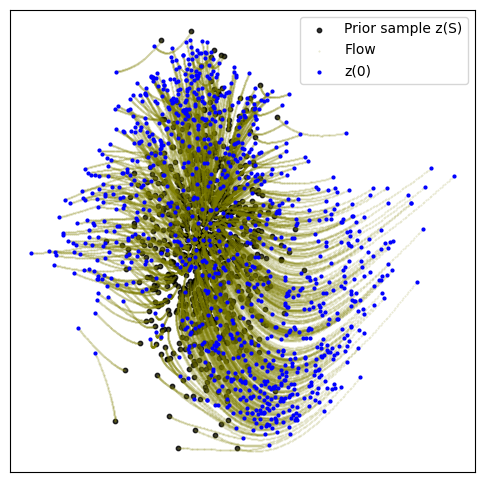

400: loss 3.232 time 107.10


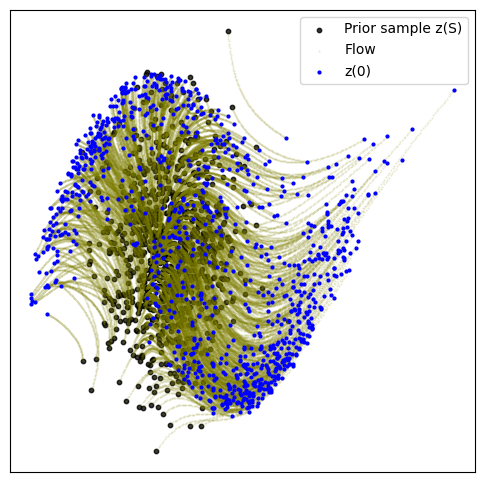

600: loss 3.492 time 132.62


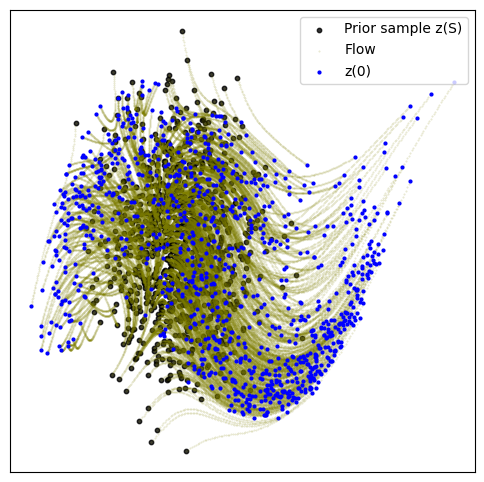

800: loss 2.939 time 134.26


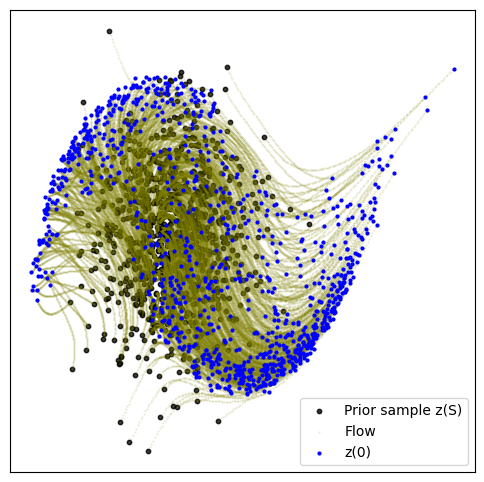

1000: loss 3.733 time 135.75


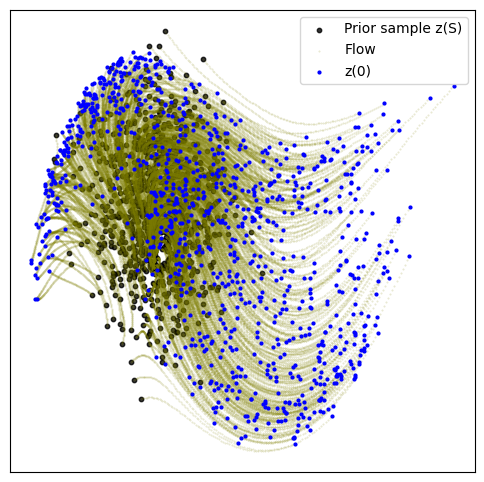

CPU times: user 10min 3s, sys: 4.5 s, total: 10min 7s
Wall time: 10min 5s


In [3]:
%%time
device = "cuda" if torch.cuda.is_available() else "cpu"
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True).to(device)
prior = MultivariateNormal(torch.zeros(dim, device=device), torch.eye(dim, device=device))
optimizer = torch.optim.Adam(model.parameters())
steps = 100
cnf = NeuralODE(
    cnf_wrapper(model, likelihood_estimator="exact"), solver="euler", sensitivity="adjoint"
)
node = NeuralODE(torch_wrapper(model), solver="euler", sensitivity="adjoint")

start = time.time()
for k in range(1000):
    optimizer.zero_grad()
    x1 = sample_moons(batch_size).to(device)
    x1_with_ll = torch.cat([x1, torch.zeros(batch_size, 1, device=device)], dim=-1)
    x0_with_ll = cnf.trajectory(x1_with_ll, t_span=torch.linspace(1, 0, steps + 1, device=device))[
        -1
    ]
    logprob = prior.log_prob(x0_with_ll[..., :-1]) + x0_with_ll[..., -1]
    loss = -torch.mean(logprob)
    loss.backward()
    optimizer.step()

    if (k + 1) % 200 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end

        with torch.no_grad():
            traj = node.trajectory(
                torch.randn(1024, 2, device=device),
                t_span=torch.linspace(0, 1, steps + 1, device=device),
            )
            plot_trajectories(traj.cpu().numpy())